In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pathlib
import glob
from PIL import Image

In [3]:
train_path = '../Food Classification/Fast Food Data/Training Data/'
data = []
for dir1 in os.listdir(train_path):
    for dir2 in os.listdir(os.path.join(train_path, dir1)):
        data.append(os.path.join(os.path.join(train_path, dir1),dir2))
train_df = pd.DataFrame({'Filepaths': data})

In [4]:
valid_path = '../Food Classification/Fast Food Data/Validation Data/'
data = []
for dir1 in os.listdir(valid_path):
    for dir2 in os.listdir(os.path.join(valid_path, dir1)):
        data.append(os.path.join(os.path.join(valid_path, dir1),dir2))
valid_df = pd.DataFrame({'Filepaths': data})

In [5]:
train_df['Labels'] = train_df['Filepaths'].apply(lambda x: ((os.path.split(x))[0].split('/'))[-1])
valid_df['Labels'] = valid_df['Filepaths'].apply(lambda x: ((os.path.split(x))[0].split('/'))[-1])

In [6]:
train_df

,Filepaths,Labels
0,../Food Classification/Fast Food Data/Training...,Burger
1,../Food Classification/Fast Food Data/Training...,Burger
2,../Food Classification/Fast Food Data/Training...,Burger
3,../Food Classification/Fast Food Data/Training...,Burger
4,../Food Classification/Fast Food Data/Training...,Burger
...,...,...
7495,../Food Classification/Fast Food Data/Training...,Sandwich
7496,../Food Classification/Fast Food Data/Training...,Sandwich
7497,../Food Classification/Fast Food Data/Training...,Sandwich
7498,../Food Classification/Fast Food Data/Training...,Sandwich


In [7]:
valid_df

,Filepaths,Labels
0,../Food Classification/Fast Food Data/Validati...,Burger
1,../Food Classification/Fast Food Data/Validati...,Burger
2,../Food Classification/Fast Food Data/Validati...,Burger
3,../Food Classification/Fast Food Data/Validati...,Burger
4,../Food Classification/Fast Food Data/Validati...,Burger
...,...,...
2495,../Food Classification/Fast Food Data/Validati...,Sandwich
2496,../Food Classification/Fast Food Data/Validati...,Sandwich
2497,../Food Classification/Fast Food Data/Validati...,Sandwich
2498,../Food Classification/Fast Food Data/Validati...,Sandwich


In [8]:
class_names = train_df['Labels'].unique()
print(class_names)

['Burger' 'Donut' 'Hot Dog' 'Pizza' 'Sandwich']


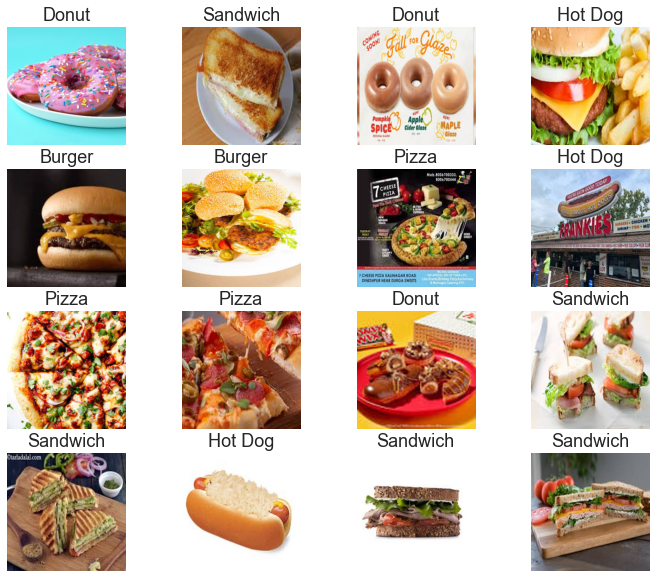

In [9]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
for i,ax in enumerate(axes.flat):
    idx = np.random.randint(1,7499)
    x = Image.open(train_df['Filepaths'][idx])
    x = x.resize((224,224))
    ax.imshow(x)
    ax.set_title(train_df['Labels'][idx],fontsize=18)
    ax.set_axis_off()
plt.show();

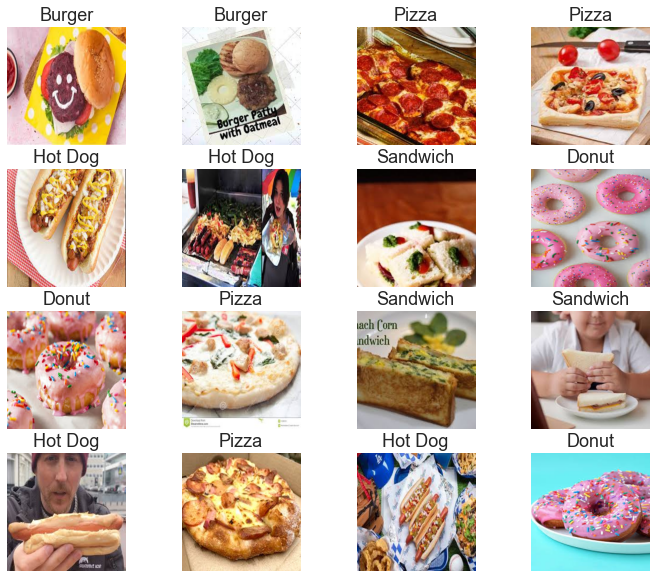

In [10]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
for i,ax in enumerate(axes.flat):
    idx = np.random.randint(1,2499)
    x = Image.open(valid_df['Filepaths'][idx])
    x = x.resize((224,224))
    ax.imshow(x)
    ax.set_title(valid_df['Labels'][idx],fontsize=18)
    ax.set_axis_off()
plt.show();

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.layers import *
from keras.models import Model

In [12]:
data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_dataset = data_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col='Filepaths',
                                                   y_col='Labels',
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True)

valid_dataset = data_generator.flow_from_dataframe(dataframe=valid_df,
                                                   x_col='Filepaths',
                                                   y_col='Labels',
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True)

Found 7500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [28]:
def make_model(base_model, train_dataset, valid_dataset, epochs, model_name):
    
    i = Input(shape=(224,224,3))
    x = base_model(i, training=False)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(i,x)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=epochs,
                        verbose=1,
                        batch_size=32,
                        callbacks=keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                mode='max',
                                                                patience=2))
    
    model.save(model_name+'.h5')
    
    plt.plot(history.history['accuracy'],c='blue')
    plt.plot(history.history['val_accuracy'],c='red')
    plt.title("Accuracy vs Validation Accuracy")
    plt.xlabel("Accuracy and Validation Accuracy")
    plt.ylabel("Epochs")
    plt.legend(["Accuracy","Validation Accuracy"], fontsize=14,loc=[1.02,0.5])
    plt.show();
    
    plt.plot(history.history['loss'],c='blue')
    plt.plot(history.history['val_loss'],c='red')
    plt.title("Loss vs Validation Loss")
    plt.xlabel("Loss and Validation Loss")
    plt.ylabel("Epochs")
    plt.legend(["Loss","Validation Loss"], fontsize=14,loc=[1.02,0.5])
    plt.show();
    
    
    result = model.evaluate(valid_dataset, verbose=0)
    print("\n")
    print('Accuracy of model is : {:.2f}%'.format(result[1]*100))
    print("\n")
    print('Loss of model is : {:.4f}'.format(result[0]))

## VGG19 model

In [29]:
base_model = keras.applications.VGG19(include_top=False,
                                      weights='imagenet',
                                      pooling='avg')
base_model.trainable = False

Epoch 1/10
235/235 [==============================] - 41s 173ms/step - loss: 1.1382 - accuracy: 0.5531 - val_loss: 0.8510 - val_accuracy: 0.6864
Epoch 2/10
235/235 [==============================] - 40s 172ms/step - loss: 0.8610 - accuracy: 0.6803 - val_loss: 0.7872 - val_accuracy: 0.7032
Epoch 3/10
235/235 [==============================] - 40s 172ms/step - loss: 0.7870 - accuracy: 0.7072 - val_loss: 0.7290 - val_accuracy: 0.7364
Epoch 4/10
235/235 [==============================] - 41s 173ms/step - loss: 0.7511 - accuracy: 0.7207 - val_loss: 0.7063 - val_accuracy: 0.7444
Epoch 5/10
235/235 [==============================] - 41s 173ms/step - loss: 0.7189 - accuracy: 0.7333 - val_loss: 0.7636 - val_accuracy: 0.7092
Epoch 6/10
235/235 [==============================] - 41s 173ms/step - loss: 0.7205 - accuracy: 0.7300 - val_loss: 0.7008 - val_accuracy: 0.7424


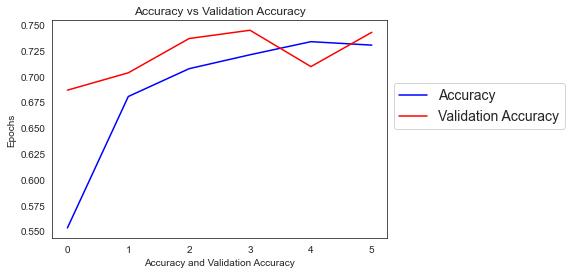

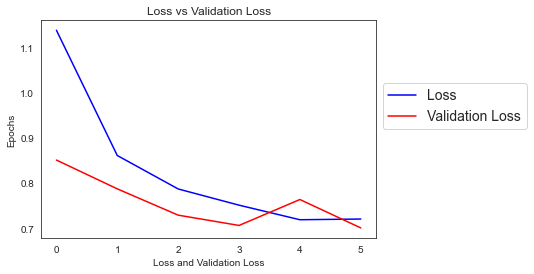



Accuracy of model is : 74.24%


Loss of model is : 0.7008


In [30]:
make_model(base_model=base_model,
           train_dataset=train_dataset,
           valid_dataset=valid_dataset,
           epochs=10,
           model_name='VGG19')

### VGG19 model prediction on random images

In [31]:
def predict_fast_food(image, model):
    img = keras.preprocessing.image.load_img(image)
    img_arr = keras.utils.img_to_array(img)
    img_arr = img_arr/255.
    img_arr = tf.image.resize(img_arr,[224,224])
    pred = np.argmax(model.predict(np.expand_dims(img_arr, axis=0)))
    prediction = class_names[pred]

    plt.figure(figsize=(2,2), dpi=200)
    plt.imshow(img)
    plt.title(prediction, fontsize=12)
    plt.axis('off')

In [39]:
from keras.models import load_model
VGG19_model = load_model('VGG19.h5')

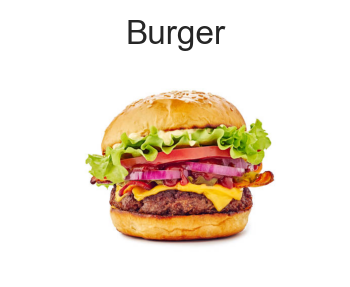

In [49]:
predict_fast_food(image='food/burger.jpg',model=VGG19_model)

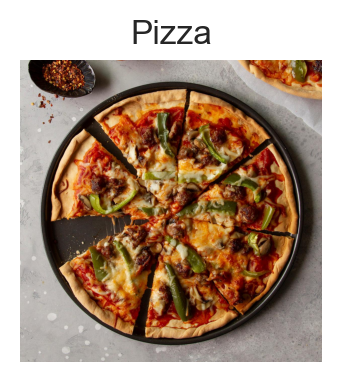

In [51]:
predict_fast_food(image='food/pizza.jpg',model=VGG19_model)

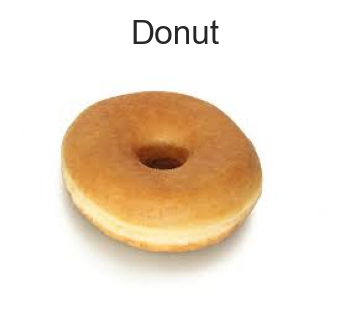

In [52]:
predict_fast_food(image='food/donut.jfif',model=VGG19_model)

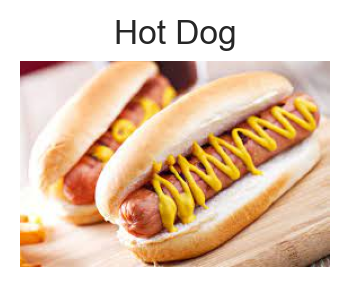

In [53]:
predict_fast_food(image='food/hotdog.jfif',model=VGG19_model)

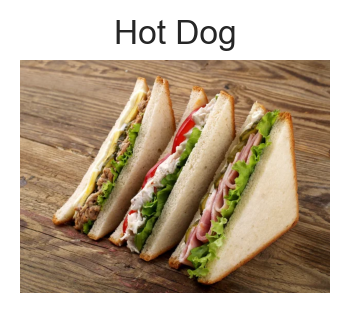

In [55]:
predict_fast_food(image='food/sandwich.jpg',model=VGG19_model)

## ResNet101V2 model

In [34]:
base_model = keras.applications.ResNet101V2(include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

Epoch 1/10
235/235 [==============================] - 45s 174ms/step - loss: 0.4685 - accuracy: 0.8512 - val_loss: 0.3777 - val_accuracy: 0.8604
Epoch 2/10
235/235 [==============================] - 39s 166ms/step - loss: 0.2827 - accuracy: 0.9059 - val_loss: 0.3847 - val_accuracy: 0.8716
Epoch 3/10
235/235 [==============================] - 39s 166ms/step - loss: 0.2357 - accuracy: 0.9183 - val_loss: 0.3847 - val_accuracy: 0.8780
Epoch 4/10
235/235 [==============================] - 39s 167ms/step - loss: 0.2064 - accuracy: 0.9320 - val_loss: 0.3703 - val_accuracy: 0.8780
Epoch 5/10
235/235 [==============================] - 39s 167ms/step - loss: 0.1785 - accuracy: 0.9415 - val_loss: 0.3657 - val_accuracy: 0.8852
Epoch 6/10
235/235 [==============================] - 39s 167ms/step - loss: 0.1500 - accuracy: 0.9499 - val_loss: 0.4278 - val_accuracy: 0.8768
Epoch 7/10
235/235 [==============================] - 39s 167ms/step - loss: 0.1443 - accuracy: 0.9516 - val_loss: 0.3769 - val_ac

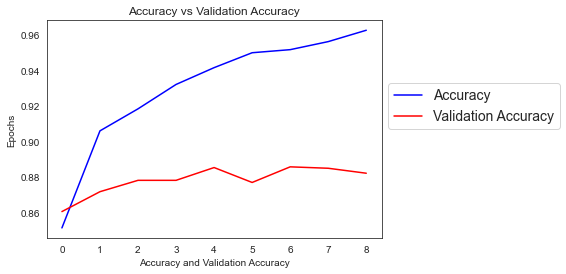

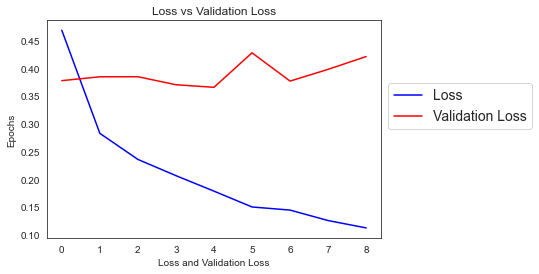



Accuracy of model is : 88.20%


Loss of model is : 0.4211


In [35]:
make_model(base_model=base_model,
           train_dataset=train_dataset,
           valid_dataset=valid_dataset,
           epochs=10,
           model_name='ResNet101V2')

In [56]:
Resnet101v2_model = load_model('ResNet101V2.h5')

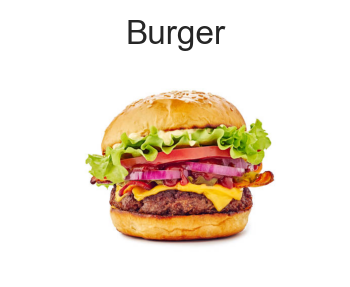

In [58]:
predict_fast_food(image='food/burger.jpg',model=Resnet101v2_model)

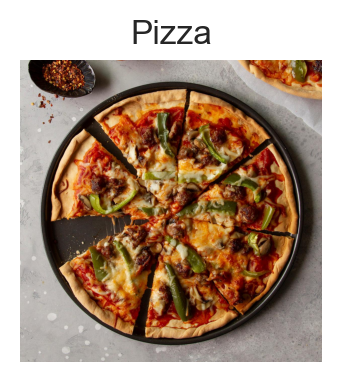

In [59]:
predict_fast_food(image='food/pizza.jpg',model=Resnet101v2_model)

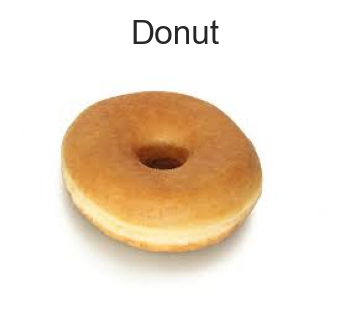

In [60]:
predict_fast_food(image='food/donut.jfif',model=Resnet101v2_model)

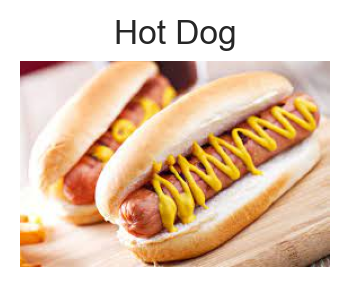

In [61]:
predict_fast_food(image='food/hotdog.jfif',model=Resnet101v2_model)

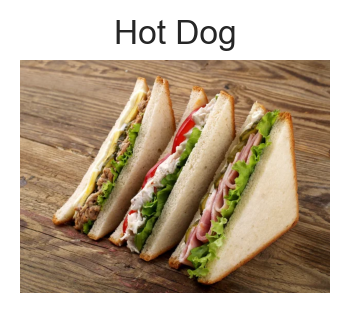

In [62]:
predict_fast_food(image='food/sandwich.jpg',model=Resnet101v2_model)